# Imports

In [111]:
import sklearn

In [112]:
imp.reload(sklearn)

<module 'sklearn' from '/Users/kamal/datapublica/companies/plugins/project-tools/python/virtualenv/lib/python3.4/site-packages/sklearn/__init__.py'>

In [851]:
import os
import json
import random
from collections import *
import re

import spacy
import en_core_web_lg
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
%config Completion.use_jedi = False

In [3]:
nlp_en = en_core_web_lg.load()

# Movie data extraction

In [4]:
movie_to_data = {}
with open("../scraped_data_20171113.json", "r") as f:
    movie_to_data = {data["movie"]:data["data"] for data in json.load(f)}

In [591]:
df = pd.read_csv("../data/title.basics.tsv.gz", sep="\t")

In [592]:
df.head()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             \N           Animation,Short  
4       0      1893      \N              1                     Short

In [593]:
df = df[(df["tconst"].isin(set(list(movie_to_data.keys()))))]

In [594]:
tconst_to_title = {d["tconst"]: d["primaryTitle"] for d in df[["tconst", "primaryTitle"]].to_dict("records")}

In [603]:
tconst_to_genre = {d["tconst"]: d["genres"] for d in df[["tconst", "genres"]].to_dict("records")}

In [781]:
del df

In [1126]:
movie_to_data.update(tconst_to_title)

In [1132]:
movie_to_synopsis = {}
with open("../scraped_data_09_02_2018.json", "r") as f:
    movie_synopsis = json.load(f)
    for movie_item in movie_synopsis:
        synopsis = " ".join(movie_item["data"]).strip()
        if "Be the first to contribute!" in synopsis:
            continue
        movie_to_synopsis[movie_item["movie"]] = synopsis

In [1135]:
movie_to_data = defaultdict(dict)
for k,v in movie_to_synopsis.items():
    movie_to_data[k]["synopsis"] = v
    movie_to_data[k]["title"] = tconst_to_title[k]

In [1136]:
with open("IMDB_SYNOPSIS_20180209.json", "w") as f:
    json.dump(movie_to_data, f)

In [8]:
os.listdir("../data")

['.DS_Store',
 'cast_data.json',
 'IMDB_FULL_DATA.json',
 'IMDB_SCRAPED_DATA.json',
 'IMDB_SYNOPSIS_20180209.json',
 'IMDB_SYNOPSIS_20180209.json.zip',
 'movies_with_cast_data_20171104.csv',
 'name.basics.tsv.gz',
 'tconst_to_worldwide_gross.json',
 'title.basics.tsv.gz',
 'title.principals.tsv.gz',
 'title.ratings.tsv.gz']

In [4]:
movie_to_data = json.load(open("../data/IMDB_SYNOPSIS_20180209.json", "r"))

In [5]:
len(movie_to_data)

4883

In [6]:
movie_to_synopsis = {key: movie["synopsis"] for key, movie in movie_to_data.items()}

In [7]:
len(movie_to_synopsis)

4883

In [8]:
movie_ids = []
list_synopsis = []
for movie_id, synopsis in movie_to_synopsis.items():
    movie_ids.append(movie_id)
    list_synopsis.append(synopsis)
movie_ids = np.array(movie_ids)

In [9]:
def explore_synopsis():
    r = random.choice(list(movie_to_synopsis.keys()))
    return r, movie_to_synopsis[r]

In [10]:
exclude_tags = set(["PROPN", "CCONJ", "X", "SPACE", "PUNCT", "-PRON-", "DET", "ADP", "PART", "NUM"])
MATRIX_TEXT_PREFIX = "TEXT_"
LEMMA_MIN_LENGTH = 3

In [11]:
URL_REGEX = "https?\:\/\/([0-9a-zA-Z\\_\-.]+)[a-z]{2,6}([\w.\/\?=#]*)*\/?"

In [194]:
with open("stopwords/english.txt", "r") as f:
    stopwords = set([r.strip() for r in f])

In [12]:
def normalize_text(text):
    return re.sub(URL_REGEX, " ", text) #removing  the url of the synopsis

In [404]:
def validate_token(token):
    if token.pos_ in exclude_tags:
        return False
    if token.lemma_ == "-PRON-" or len(token.lemma_) <= LEMMA_MIN_LENGTH or token.lemma_ in stopwords:
        return False
    return True

In [405]:
def build_document_frequency(doc):
    lemma_to_count = defaultdict(int)
    for idx, token in enumerate(doc):
        if validate_token(token):
            lemma_to_count[MATRIX_TEXT_PREFIX + token.lemma_] += 1
    return lemma_to_count

In [209]:
def build_corpus(list_of_texts):
    corpus = list()
    for text in tqdm(list_of_texts):
        if len(text):
            #Normalize text
            text = normalize_text(text)
            # Tokenization & Lemmatization
            doc = nlp_en(text)
            # Calcul des Occurences
            doc_frequency = build_document_frequency(doc)
            corpus.append(doc_frequency)
        else:
            corpus.append({})
    return corpus

In [197]:
with open("keywords_to_movie.json", "r") as f:
    keywords_to_movie = json.load(f)

In [198]:
movie_sample = [movie for v in keywords_to_movie.values() for movie in v]

In [199]:
sampled_synopsis = list()
sampled_movie_ids = list()
for item in movie_sample:
    if movie_to_synopsis.get(item):
        sampled_synopsis.append(movie_to_synopsis[item])
        sampled_movie_ids.append(item)

In [210]:
corpus_ = build_corpus(sampled_synopsis)

100%|██████████| 143/143 [02:07<00:00,  1.12it/s]


In [211]:
vectorizer_ = DictVectorizer() 

In [212]:
matrix = vectorizer_.fit_transform(corpus_)

In [213]:
matrix.shape

(143, 9929)

In [28]:
vocab = np.array(vectorizer.get_feature_names())

In [29]:
matrix.shape

(143, 9929)

In [30]:
np.argwhere(matrix.sum(axis=1).A1 < 1)

array([[46]])

In [31]:
sampled_movie_ids[140]

'tt2250912'

In [32]:
# features having a DF at 1 (appearing in one single document of the corpus)
random.sample(list(vocab[np.argwhere(matrix.astype(np.bool).sum(axis=0).A1 == 1).reshape(-1)]), 10)

['TEXT_shirk',
 'TEXT_subsurface',
 'TEXT_barrio',
 'TEXT_maniac',
 'TEXT_walkman',
 'TEXT_spender',
 'TEXT_pager',
 'TEXT_vase',
 'TEXT_reservoir',
 'TEXT_indecisive']

In [33]:
max_occurence = 80
stop_words_idx = np.argwhere(matrix.astype(np.bool).sum(axis=0).A1 > max_occurence).reshape(-1)
vocab[stop_words_idx]

array(['TEXT_again', 'TEXT_all', 'TEXT_arrive', 'TEXT_ask', 'TEXT_attempt',
       'TEXT_away', 'TEXT_back', 'TEXT_become', 'TEXT_begin', 'TEXT_break',
       'TEXT_bring', 'TEXT_call', 'TEXT_can', 'TEXT_come', 'TEXT_conjurer',
       'TEXT_continue', 'TEXT_day', 'TEXT_dead', 'TEXT_death',
       'TEXT_decide', 'TEXT_die', 'TEXT_end', 'TEXT_escape', 'TEXT_even',
       'TEXT_explain', 'TEXT_face', 'TEXT_fall', 'TEXT_find',
       'TEXT_follow', 'TEXT_force', 'TEXT_get', 'TEXT_give', 'TEXT_good',
       'TEXT_hand', 'TEXT_have', 'TEXT_head', 'TEXT_help', 'TEXT_hold',
       'TEXT_home', 'TEXT_how', 'TEXT_however', 'TEXT_just', 'TEXT_keep',
       'TEXT_kill', 'TEXT_know', 'TEXT_last', 'TEXT_late', 'TEXT_lead',
       'TEXT_learn', 'TEXT_leave', 'TEXT_life', 'TEXT_live', 'TEXT_look',
       'TEXT_make', 'TEXT_man', 'TEXT_meanwhile', 'TEXT_meet', 'TEXT_much',
       'TEXT_name', 'TEXT_new', 'TEXT_next', 'TEXT_not', 'TEXT_now',
       'TEXT_only', 'TEXT_open', 'TEXT_order', 'TEXT_other', '

In [34]:
keep_words = np.ones(matrix.shape[1], dtype=np.bool)
keep_words[stop_words_idx] = False
vocab = vocab[keep_words]
matrix = matrix[:, keep_words]

In [35]:
matrix.shape

(143, 9825)

In [36]:
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(matrix)

# SVD - Singular Value Decomposition

In [37]:
term_doc = tfidf_matrix.todense().T

In [38]:
U, S, V = np.linalg.svd(term_doc, full_matrices=False)

In [39]:
print(" U : %(U)s \n S : %(S)s [diagonal] \n V: %(V)s " %({"U": str(U.shape), "S": str(S.shape), "V": str(V.shape)}))

 U : (9825, 143) 
 S : (143,) [diagonal] 
 V: (143, 143) 


In [40]:
# Confirm it is a decomposition of the initial matrix : 
np.allclose(np.multiply(U, S).dot(V), term_doc)

True

In [41]:
np.allclose(U.T.dot(U), np.eye(U.shape[1])) # U is orthonormal (all its columns (topics) are orthonormal)

True

In [42]:
np.allclose(V.dot(V.T), np.eye(V.shape[0])) # V is orthonormal as well 

True

In [43]:
np.allclose(U[:,1].A1.dot(U[:,2].A1), 0) # U columns are orthogonal (topics are orthonormal)

True

In [44]:
np.allclose(V[1,:].A1.dot(V[2,:].A1), 0) # V rows are orthogonal (topics are orthonormal)

True

In [45]:
# topics

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(S)
plt.grid()
plt.title("Eigen Values of the Matrix in decreasing order")

Text(0.5,1,'Eigen Values of the Matrix in decreasing order')

Text(0.5,1,'15 first best Eigen Values of the Matrix in decreasing order')

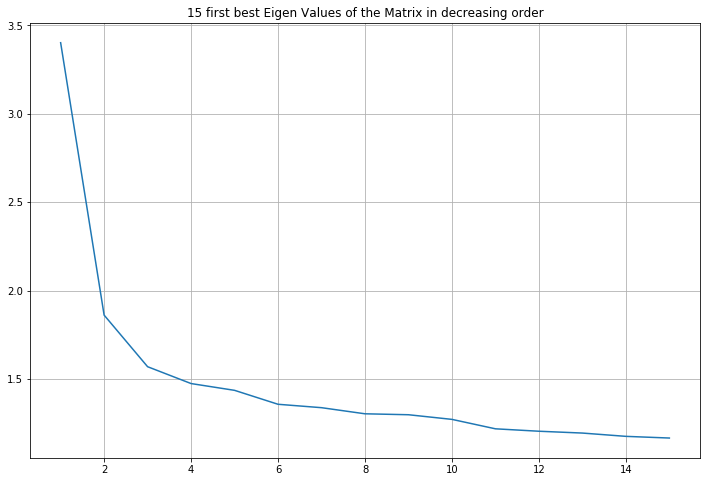

In [47]:
max_n = 15
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_n+1), S[:max_n])
plt.grid()
plt.title("%d first best Eigen Values of the Matrix in decreasing order" % max_n)

In [48]:
term_doc.shape

(9825, 143)

In [49]:
vocab.shape

(9825,)

In [50]:
U.shape

(9825, 143)

In [51]:
vocab[np.flipud(np.argsort(U[:,:1].A1))[:15]]

array(['TEXT_absentee', 'TEXT_lowdown', 'TEXT_intimidation', 'TEXT_faze',
       'TEXT_rug', "TEXT_d'arcy", 'TEXT_backlash', 'TEXT_critic',
       'TEXT_tirelessly', 'TEXT_mediation', 'TEXT_sexuality', 'TEXT_rile',
       'TEXT_shitty', 'TEXT_liability', 'TEXT_bisexual'],
      dtype='<U24')

In [52]:
vocab[np.flipud(np.argsort(U[:,2].A1))[:25]] #related to war

array(['TEXT_soldier', 'TEXT_german', 'TEXT_tank', 'TEXT_squad',
       'TEXT_cinema', 'TEXT_bunker', 'TEXT_japanese', 'TEXT_camp',
       'TEXT_british', 'TEXT_war', 'TEXT_film', 'TEXT_boat',
       'TEXT_chapter', 'TEXT_auditorium', 'TEXT_troop', 'TEXT_officer',
       'TEXT_fire', 'TEXT_sniper', 'TEXT_jewish', 'TEXT_french',
       'TEXT_machine', 'TEXT_nazi', 'TEXT_tavern', 'TEXT_surrender',
       'TEXT_command'],
      dtype='<U24')

In [53]:
vocab[np.flipud(np.argsort(U[:,3].A1))[:25]] 

array(['TEXT_bond', 'TEXT_enterprise', 'TEXT_ship', 'TEXT_captain',
       'TEXT_diamond', 'TEXT_beam', 'TEXT_imperial', 'TEXT_bridge',
       'TEXT_torpedo', 'TEXT_crow', 'TEXT_car', 'TEXT_fleet', 'TEXT_warp',
       'TEXT_droid', 'TEXT_destroy', 'TEXT_damage', 'TEXT_rocket',
       'TEXT_henchman', 'TEXT_sub', 'TEXT_mission', 'TEXT_plan',
       'TEXT_planet', 'TEXT_code', 'TEXT_moon', 'TEXT_father'],
      dtype='<U24')

In [54]:
vocab[np.flipud(np.argsort(U[:,5].A1))[:25]] #topics related to war

array(['TEXT_father', 'TEXT_imperial', 'TEXT_droid', 'TEXT_mother',
       'TEXT_mutant', 'TEXT_police', 'TEXT_battle', 'TEXT_fleet',
       'TEXT_power', 'TEXT_city', 'TEXT_love', 'TEXT_rebel', 'TEXT_fight',
       'TEXT_old', 'TEXT_train', 'TEXT_family', 'TEXT_ability',
       'TEXT_young', 'TEXT_friend', 'TEXT_track', 'TEXT_sister',
       'TEXT_army', 'TEXT_fly', 'TEXT_lightsaber', 'TEXT_house'],
      dtype='<U24')

In [55]:
vocab[np.flipud(np.argsort(U[:,10].A1))[:25]]

array(['TEXT_ship', 'TEXT_tank', 'TEXT_german', 'TEXT_camp',
       'TEXT_prisoner', 'TEXT_ghetto', 'TEXT_jewish', 'TEXT_tuvia',
       'TEXT_imperial', 'TEXT_guard', 'TEXT_hilt', 'TEXT_droid',
       'TEXT_rocket', 'TEXT_hide', 'TEXT_uncle', 'TEXT_child', 'TEXT_sun',
       'TEXT_troop', 'TEXT_prison', 'TEXT_partisan', 'TEXT_wood',
       'TEXT_game', 'TEXT_tunnel', 'TEXT_grace', 'TEXT_officer'],
      dtype='<U24')

In [561]:
def show_topics(topics_ids, matrix, vocab, max_words_in_topic = 25):
    if hasattr(matrix, "A1"):
        get_topics = lambda t: vocab[np.flipud(np.argsort(matrix[:,t].A1))[:max_words_in_topic]]
    else:
        get_topics = lambda t: vocab[np.flipud(np.argsort(matrix[:,t]))[:max_words_in_topic]]
    for i in topics_ids:
        print("Topic %d" % (i))
        print(" ".join([topic[topic.index("_")+1:] for topic in get_topics(i)]))
        print("*"*40)

In [58]:
U.shape

(9825, 143)

In [59]:
S.shape

(143,)

In [60]:
V.shape

(143, 143)

In [65]:
[movie_to_data[t]["title"] for t in np.array(sampled_movie_ids)[np.flipud(np.argsort(V[1,:].A1))[:10]]] # movies related to the space topic

['Pitch Black',
 'Star Trek: The Motion Picture',
 'Alien',
 'Alien: Resurrection',
 'Event Horizon',
 'Star Trek',
 'Star Trek: Nemesis',
 'Star Trek Into Darkness',
 'Pandorum',
 'Sunshine']

In [66]:
[movie_to_data[t]["title"] for t in np.array(sampled_movie_ids)[np.flipud(np.argsort(V[2,:].A1))[:10]]] # movies related to the space topic

['Saving Private Ryan',
 'Inglourious Basterds',
 'Inglourious Basterds',
 'Dunkirk',
 'Fury',
 'Hacksaw Ridge',
 'Downfall',
 'Enemy at the Gates',
 'Life Is Beautiful',
 'The Bridge on the River Kwai']

In [67]:
topic_keep_support = np.zeros(V.shape[0], dtype=np.bool)

In [68]:
topic_keep_support[1] = True
topic_keep_support[2] = True

In [69]:
X_ = V[topic_keep_support, :][0,:].A1
Y_ = V[topic_keep_support, :][1,:].A1

In [70]:
movie_titles = [movie_to_data[t]["title"] for t in sampled_movie_ids]

In [72]:
fig, ax = plt.subplots(**{"figsize": (40, 40)})
ax.scatter(X_, Y_)
for idx, name in enumerate(movie_titles):
    ax.text(X_[idx], Y_[idx], name, fontdict={"fontsize": 20})
plt.grid()
plt.title("Representation of the movies on the first & 2nd eigen values", fontdict={"fontsize": 40})

Text(0.5,1,'Representation of the movies on the first & 2nd eigen values')

## Truncated SVD

In [73]:
from sklearn.decomposition import TruncatedSVD

In [74]:
truncated_svd = TruncatedSVD(n_components=100)

In [75]:
reduced_term_doc = truncated_svd.fit_transform(matrix)

## Clustering

In [76]:
from sklearn.cluster import KMeans

In [77]:
kmeans = KMeans(n_clusters=10)

In [78]:
clusters = kmeans.fit_transform(reduced_term_doc)

In [79]:
clusters.shape

(143, 10)

In [80]:
item_to_cluster = {}

In [81]:
cluster_assigns = np.array([np.argmin(clusters[idx,:]) for idx in range(clusters.shape[0])])

In [98]:
np.array(movie_titles)[np.argwhere(cluster_assigns == 0).reshape(-1)]

array(['Saving Private Ryan', 'Fury',
       'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
       'Defiance'],
      dtype='<U62')

# NMF - Non negative Matrix Factorization

In [ ]:
# Original dataset need to be non-negative (it is the case for text corpus)

In [99]:
matrix.T.shape

(9825, 143)

In [103]:
nmf_factorizer = NMF(n_components=20)

In [109]:
W = nmf_factorizer.fit_transform(tfidf_matrix.todense().T)
H = nmf_factorizer.components_

In [110]:
W.shape, H.shape

((9825, 20), (20, 143))

In [111]:
W.dot(H).shape

(9825, 143)

In [112]:
W.dot(H).shape

(9825, 143)

In [113]:
show_topics(4, W, vocab)

Topic 0
car police money drug bank hostage guy cop phone officer member mask gun drive mob team tunnel street office put mexican prison tiger arrest sheikh
****************************************
Topic 1
ship planet crow pod creature space rocket sun gravity bridge fight prison moon payload mission destroy hangar group power passenger stab bow human necromonger fly
****************************************
Topic 2
soldier german tank squad boat sniper troop beach fire desmond unit wound water field gun british grenade group packard fury hit brother train tend bomb
****************************************
Topic 3
alien creature signal heptapod human site egg clone marine sunglass language facehugger module vessel planet ship strange glass suddenly symbol flamethrower cell asthma army crow
****************************************


In [192]:
np.array(movie_titles)[np.argwhere(H[0,:] > 0).reshape(-1)]

array(['A Clockwork Orange', 'Captain America: The First Avenger',
       'The Pianist', 'X-Men Origins: Wolverine', 'The Wolverine',
       "It's a Wonderful Life", 'Hacksaw Ridge', 'The Aviator', 'Hellboy',
       'Valkyrie', 'Thank You for Smoking', 'Kong: Skull Island', 'Gandhi',
       'Munich', 'The Great Escape', 'The Bridge on the River Kwai',
       'Guardians of the Galaxy', 'Aliens', 'Star Trek', 'Life of Brian',
       'Serenity', 'Fantastic 4: Rise of the Silver Surfer', 'Spaceballs',
       'Pandorum', 'Evolution', 'The Meaning of Life',
       'Transformers: The Last Knight', 'They Live', 'The Dark Knight',
       'The Dark Knight Rises', 'Batman Begins', 'The Departed', 'Memento',
       'The Wolf of Wall Street', 'V for Vendetta', 'Gone Girl',
       'Donnie Darko', 'Catch Me If You Can', 'The Hangover', 'Iron Man 3',
       'Skyfall', 'World War Z', 'Now You See Me', 'Prisoners', 'I, Robot',
       'Watchmen', 'American Psycho', 'Hot Fuzz', 'American Hustle',
       '

In [193]:
np.array(movie_titles)[np.argwhere(H[2,:] > 0).reshape(-1)]

array(['Inglourious Basterds', 'Saving Private Ryan',
       'Captain America: The First Avenger', 'The Imitation Game',
       "The King's Speech", "Pan's Labyrinth", 'Life Is Beautiful',
       'Casablanca', 'The Wolverine', 'Fury', 'Dunkirk',
       "It's a Wonderful Life",
       'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
       'Hacksaw Ridge', 'Downfall', 'Pearl Harbor', 'Hellboy', 'Atonement',
       'Enemy at the Gates', 'Valkyrie', 'Kong: Skull Island', 'Gandhi',
       'Das Boot', 'Munich', 'The Great Escape', 'Grave of the Fireflies',
       'Memoirs of a Geisha', 'Defiance',
       'Star Wars: Episode IV - A New Hope', 'Avatar',
       'Star Wars: Episode V - The Empire Strikes Back', 'Gravity',
       'Aliens', 'Star Trek', 'Serenity', 'The Chronicles of Riddick',
       'Event Horizon', 'Evolution', 'Transformers: The Last Knight',
       'Planet 51', 'The Dark Knight', 'The Dark Knight Rises',
       'Batman Begins', 'Inglourious Basterds', 'The De

In [115]:
W.shape

(9825, 20)

In [170]:
kmeans_nmf = KMeans(n_clusters=7)

In [171]:
nmf_clusters = kmeans_nmf.fit_transform(H.T)

In [172]:
nmf_clusters.shape

(143, 7)

In [173]:
cluster_nmf_assigns = np.array([np.argmin(nmf_clusters[idx,:]) for idx in range(nmf_clusters.shape[0])])

In [174]:
Counter(cluster_nmf_assigns)

Counter({0: 12, 1: 3, 2: 4, 3: 86, 4: 20, 5: 8, 6: 10})

In [175]:
np.array(movie_titles)[np.argwhere(cluster_nmf_assigns == 0).reshape(-1)]

array(['Saving Private Ryan', 'Captain America: The First Avenger', 'Fury',
       'Dunkirk', 'Hacksaw Ridge', 'The Aviator', 'Pearl Harbor',
       'Enemy at the Gates', 'Airplane!', 'The English Patient',
       'The Fifth Element', 'Fast & Furious 6'],
      dtype='<U62')

In [176]:
np.array(movie_titles)[np.argwhere(cluster_nmf_assigns == 1).reshape(-1)]

array(['Diamonds Are Forever', 'Skyfall', 'Spectre'],
      dtype='<U62')

In [177]:
np.array(movie_titles)[np.argwhere(cluster_nmf_assigns == 2).reshape(-1)]

array(['Star Trek', 'Star Trek Into Darkness',
       'Star Trek: The Motion Picture', 'Star Trek: Nemesis'],
      dtype='<U62')

In [178]:
for item in range(0, len(set(cluster_nmf_assigns))):
    print(item)
    print(np.array(movie_titles)[np.argwhere(cluster_nmf_assigns == item).reshape(-1)])
    print("*" * 100)

0
['Saving Private Ryan' 'Captain America: The First Avenger' 'Fury'
 'Dunkirk' 'Hacksaw Ridge' 'The Aviator' 'Pearl Harbor'
 'Enemy at the Gates' 'Airplane!' 'The English Patient' 'The Fifth Element'
 'Fast & Furious 6']
****************************************************************************************************
1
['Diamonds Are Forever' 'Skyfall' 'Spectre']
****************************************************************************************************
2
['Star Trek' 'Star Trek Into Darkness' 'Star Trek: The Motion Picture'
 'Star Trek: Nemesis']
****************************************************************************************************
3
['Inglourious Basterds' 'Shutter Island' 'The Imitation Game'
 "The King's Speech" "Pan's Labyrinth"
 'The Curious Case of Benjamin Button' 'X-Men' 'The Notebook'
 'X-Men Origins: Wolverine' 'The Wolverine'
 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe'
 'The Others' 'Downfall' 'Hellboy' 'Atonement' 'Valkyrie'

# Reducing the whole corpus

In [15]:
whole_synopsis = list()
whole_movie_ids = list()
whole_movie_titles = list()
for movieId, data in movie_to_data.items():
    whole_synopsis.append(movie_to_synopsis[movieId])
    whole_movie_ids.append(movieId)
    whole_movie_titles.append(data["title"])

In [16]:
whole_movie_titles = np.array(whole_movie_titles)

In [17]:
corpus = build_corpus(whole_synopsis)

100%|██████████| 4883/4883 [32:16<00:00,  2.52it/s]


In [18]:
dict_vectorizer = DictVectorizer()

In [19]:
whole_matrix = dict_vectorizer.fit_transform(corpus)

In [20]:
vocabulary = np.array(dict_vectorizer.get_feature_names())

In [21]:
whole_matrix.shape

(4883, 31080)

In [22]:
plt.figure(figsize=(12, 8))
sns.distplot(whole_matrix.astype(np.bool).sum(axis=1).A1, kde=False)
plt.grid()
plt.title("Distribution of the number of words in IMDB synopsis")

Text(0.5,1,'Distribution of the number of words in IMDB synopsis')

In [23]:
# filter on word frequency 

In [24]:
# -- nb words occuring in one single document 
keep_words = np.argwhere(whole_matrix.astype(np.bool).sum(axis=0).A1 > 1).reshape(-1)

In [25]:
whole_matrix.shape[1] - keep_words.shape[0]

11784

In [26]:
print(random.sample(list(vocabulary[np.argwhere(whole_matrix.astype(np.bool).sum(axis=0).A1 == 1).reshape(-1)]), 100))

['TEXT_manger', 'TEXT_myeloid', 'TEXT_anj', 'TEXT_fuller', 'TEXT_racy', 'TEXT_ponderer', 'TEXT_miscarrage', 'TEXT_homeand', 'TEXT_pils', 'TEXT_ladrón', 'TEXT_snubfighter', 'TEXT_entrepeneur', 'TEXT_pulsera', 'TEXT_compositon', 'TEXT_gunrunner', 'TEXT_compromiz', 'TEXT_brightness', 'TEXT_t.k.s', 'TEXT_forclos', 'TEXT_resurgent', 'TEXT_willow', 'TEXT_stopper', 'TEXT_contruction', 'TEXT_humidifier', 'TEXT_bullshittin', 'TEXT_becomm', 'TEXT_vehicularly', 'TEXT_injun', 'TEXT_pertinent', 'TEXT_seizer', 'TEXT_busrt', 'TEXT_klown', 'TEXT_nonthreatening', 'TEXT_identificativa', 'TEXT_sundowning', 'TEXT_topcoat', 'TEXT_dunderheaded', 'TEXT_scepticism', 'TEXT_pinging', 'TEXT_off--', 'TEXT_ree', 'TEXT_future-', 'TEXT_azamat', 'TEXT_sanitizer', 'TEXT_5:40am', 'TEXT_bray', 'TEXT_microbot', 'TEXT_worksuit', 'TEXT_uninvolvedness', 'TEXT_tediously', 'TEXT_-green', 'TEXT_supersize', 'TEXT_preplanned', 'TEXT_interchangeable', 'TEXT_fishermans', 'TEXT_incrementally', 'TEXT_wickedness', 'TEXT_babitch', 'TE

In [27]:
whole_matrix = whole_matrix[:, keep_words]

In [28]:
vocabulary = vocabulary[keep_words]

In [29]:
vocabulary[whole_matrix.astype(np.bool).sum(axis=0).A1 > 2000]

array(['TEXT_again', 'TEXT_all', 'TEXT_arrive', 'TEXT_ask', 'TEXT_attempt',
       'TEXT_away', 'TEXT_back', 'TEXT_become', 'TEXT_begin', 'TEXT_break',
       'TEXT_bring', 'TEXT_call', 'TEXT_can', 'TEXT_come', 'TEXT_conjurer',
       'TEXT_day', 'TEXT_decide', 'TEXT_doe', 'TEXT_end', 'TEXT_escape',
       'TEXT_even', 'TEXT_fall', 'TEXT_find', 'TEXT_follow', 'TEXT_friend',
       'TEXT_get', 'TEXT_give', 'TEXT_good', 'TEXT_hand', 'TEXT_have',
       'TEXT_head', 'TEXT_help', 'TEXT_home', 'TEXT_house', 'TEXT_how',
       'TEXT_however', 'TEXT_just', 'TEXT_kill', 'TEXT_know', 'TEXT_late',
       'TEXT_lead', 'TEXT_leave', 'TEXT_life', 'TEXT_live', 'TEXT_look',
       'TEXT_make', 'TEXT_man', 'TEXT_meet', 'TEXT_much', 'TEXT_name',
       'TEXT_new', 'TEXT_next', 'TEXT_night', 'TEXT_not', 'TEXT_now',
       'TEXT_old', 'TEXT_only', 'TEXT_open', 'TEXT_other', 'TEXT_own',
       'TEXT_place', 'TEXT_realize', 'TEXT_return', 'TEXT_reveal',
       'TEXT_room', 'TEXT_run', 'TEXT_say', 'TEXT_see

## TF.idf normalization 

In [31]:
tfdif_tr = TfidfTransformer()
matrix_tfidf = tfdif_tr.fit_transform(whole_matrix)

## Dimensional reduction using NMF

In [42]:
vocab = vocabulary

In [34]:
nmf_ = NMF(n_components=100)

In [37]:
W = nmf_.fit_transform(matrix_tfidf)

In [39]:
H = nmf_.components_

In [38]:
W.shape

(4883, 100)

In [562]:
show_topics(range(0, 10), H.T, vocab, 35)

Topic 0
say ask not look see talk walk have want back there what how come sit why think know get leave will call just would people can yes should smile take reply drink need cry something
****************************************
Topic 1
kill shoot gun dead assassin who head fire bullet wound attack weapon rifle pistol target then escape death thug take hand man order grab henchman knife tell die know arm sniper body hide pull beat
****************************************
Topic 2
love marry fall marriage letter when never heart return together leave feeling become kiss meet true lover can year realize fear make happy beautiful confess see come arrange plan life spend who friendship only romantic
****************************************
Topic 3
door room see look open back light run grab scream hear window begin suddenly floor body head walk hand find upstairs wall bed turn face pull blood try come lock basement sit when fall figure
****************************************
Topic 4
ship p

## Dimension reduction SVD

In [83]:
svd = TruncatedSVD(n_components=100)

In [115]:
matrix_tfidf.shape

(4883, 19296)

In [100]:
svd = svd.fit(matrix_tfidf)

In [101]:
svd.components_.shape

(100, 19296)

In [262]:
show_topics(range(0, 6), svd.components_.T, vocab, 35)

Topic 0
have not tell get who when see say take find then will man back leave kill can ask make where car try house come which that call there other much home want give meet time
****************************************
Topic 1
kill escape ship shoot attack who soldier gang crow police man team attempt order alien destroy use find bomb capture group force officer fight bond battle murder human manage death mission discover weapon rescue reveal
****************************************
Topic 2
car say tell get shoot gun kill door then cop see man room police ask look drive grab back pull head run phone truck walk call open window there dead killer fire body hear try
****************************************
Topic 3
ship alien say creature crow human vampire planet see can soldier not power fly destroy monster space water back will what island castle battle that attack zombie there door world land voice look enterprise come
****************************************
Topic 4
house mother chil

In [105]:
matrix_truncated = svd.transform(matrix_tfidf)

## Comparing clustering

In [113]:
from sklearn.cluster import KMeans

### Based on NMF-reduced matrice

In [120]:
kmeans = KMeans(n_clusters=20)

In [121]:
nmf_clusters = kmeans.fit_transform(W)

In [122]:
nmf_clusters.shape

(4883, 20)

In [130]:
nmf_cluster_assigns = np.array([np.argmin(distances) for distances in nmf_clusters])

In [143]:
plt.figure(figsize=(12, 8))
sns.countplot(nmf_cluster_assigns, palette=c_palette)
plt.grid()
plt.title("# of items by cluster ID - NMF")

Text(0.5,1,'# of items by cluster ID - NMF')

In [269]:
def get_cluster_vocab(cluster_id, assignment, max_keywords=30, max_movies=15):
    movies = whole_movie_titles[assignment == cluster_id]
    print("Cluster has %d movies" % len(movies))
    lim = min(max_movies, len(movies))
    m = matrix_tfidf[assignment == cluster_id,:]
    column_sum = (m.sum(axis=0) > 1).A1
    best_keywords_ids = np.flipud(np.argsort(m.sum(axis=0).A1))
    return np.array(random.sample(list(movies), lim)), best_keywords_ids[:max_keywords]

In [315]:
cluster_movies, cluster_best_keywords = get_cluster_vocab(5, nmf_cluster_assigns)

Cluster has 325 movies


In [316]:
cluster_movies

array(['The Pink Panther 2', 'As Good as It Gets',
       'The Last House on the Left', 'The Shack', 'Split', 'Honeymoon',
       'Red River', 'High Plains Drifter', 'Cat Ballou',
       'Love & Other Drugs', 'Lucky Number Slevin', 'Hud',
       'Scott Pilgrim vs. the World', 'Whip It', 'Manchester by the Sea'],
      dtype='<U27')

### Using SVD reduced matrice

In [136]:
c_palette = sns.color_palette("Blues", 1)

In [117]:
kmeans_ = KMeans(n_clusters=20)

In [118]:
svd_clusters = kmeans_.fit_transform(matrix_truncated)

In [140]:
svd_cluster_assigns = np.array([np.argmin(distances) for distances in svd_clusters])

Text(0.5,1,'# of items by cluster ID - SVD')

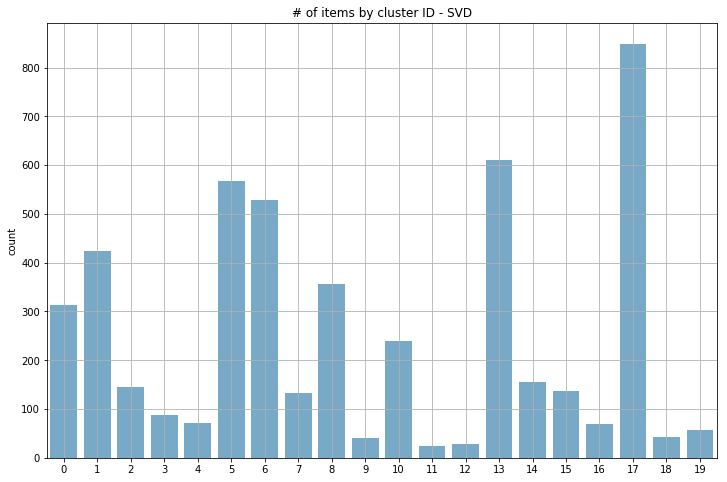

In [141]:
plt.figure(figsize=(12, 8))
sns.countplot(svd_cluster_assigns, palette=c_palette)
plt.grid()
plt.title("# of items by cluster ID - SVD")

In [395]:
cluster_movies, cluster_best_keywords = get_cluster_vocab(16, svd_cluster_assigns)

Cluster has 70 movies


In [396]:
cluster_movies

array(['Music and Lyrics', 'Casablanca', 'Sing Street', 'La La Land',
       'Nashville', 'The Phantom of the Opera', 'Straight Outta Compton',
       'Get on Up', 'Sing', 'Green Room', 'Ricki and the Flash',
       'Scott Pilgrim vs. the World', 'Hedwig and the Angry Inch',
       'Jersey Boys', 'A Night at the Opera'],
      dtype='<U27')

In [397]:
best_topics = np.flipud(np.argsort(svd.components_.T[cluster_best_keywords,:].sum(axis=0)))[:3]

In [563]:
show_topics(best_topics, svd.components_.T, vocab)

Topic 0
have not tell get who when see say take find then will man back leave kill can ask make where car try house come which
****************************************
Topic 21
band have song killer play music father sing tell soldier perform stage record house singer rock performance alien family town dance murder show car son
****************************************
Topic 16
bond zombie gang money game father will play band town alien say drug boy win brother steal bank world room film pay gold mi6 ship
****************************************


In [399]:
# --> topics have comon words, and do not seem that "orthonormal" in a vocabulary sense

In [400]:
# --> let's try with bigrams

# Bigram using Gensim

In [460]:
import gensim
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phraser

In [486]:
def sentencize_corpus(documents, n_threads):
    documents = [normalize_text(document) for document in documents]
    for parsed_document in nlp_en.pipe(documents, n_threads=n_threads):
        for sentence in parsed_document.sents:
            yield " ".join([token.lemma_ for token in sentence if validate_token(token)])

In [426]:
with open("SYNOPSIS_SENTENCES.txt", "w", encoding="utf-8") as f:
    for sentence in sentencize_corpus(whole_synopsis):
        f.write(sentence + '\n')

In [427]:
with open("SYNOPSIS_SENTENCES.txt", "r") as f:
    sents = [r.strip() for r in f.readlines()]

In [461]:
unigram_sentences = LineSentence("SYNOPSIS_SENTENCES.txt")

In [463]:
bigram_model = Phrases(unigram_sentences)

In [488]:
def pipeline(texte, n_threads=4):
    document_tf = defaultdict(int)
    for sentence in sentencize_corpus([texte], n_threads):
        result = bigram_model[sentence.split(" ")]
        for r in result:
            document_tf[r] += 1
    return document_tf

In [465]:
syn = random.choice(whole_synopsis)

In [467]:
pipeline(syn)

defaultdict(int,
            {'accept': 1,
             'accuracy': 1,
             'accuse': 2,
             'acquit': 1,
             'action': 1,
             'activity': 1,
             'addition': 1,
             'additional': 1,
             'address': 1,
             'adjacent': 1,
             'agency': 1,
             'agent': 2,
             'airport': 2,
             'allege': 3,
             'allegedly': 1,
             'allow': 1,
             'anti': 1,
             'anyone': 1,
             'apartment': 1,
             'apologize': 1,
             'approach': 1,
             'argue': 1,
             'arrest': 2,
             'assassin': 3,
             'assassinate': 1,
             'assassination': 15,
             'asset': 1,
             'associate': 1,
             'attack': 3,
             'attempt': 1,
             'attempt_assassinate': 1,
             'back': 4,
             'beat': 2,
             'become': 2,
             'believe': 3,
             'black': 1,


In [468]:
for i in range(0, 20):
    print([key for key in pipeline(random.choice(whole_synopsis)) if "_" in key ])

['kind_hearted', 'high_school', 'police_detective', 'give_makeover', 'snap_picture', 'nothing_happen', 'later_night', 'decompose_body', 'acceptance_speech', 'open_scene', 'open_trunk', 'senior_prom', 'feel_remorse', 'duct_tape', 'take_pity', 'reveal_truth', 'choke_death', 'cold_blood', 'fabricate_story', 'much_popular', 'well_friend', 'reveal_true', 'fake_death']
['loan_shark', 'tell_truth']
['someone_else', 'fall_apart', 'dinner_party', 'mind_control', 'propose_accept', 'swallow_pride', 'feel_guilty', 'insane_asylum', 'feel_responsible', 'leave_alone']
['strangle_death', 'receive_word', 'laptop_computer', 'stab_death', 'explosive_charge', 'phone_numb', 'lose_control', 'grab_rifle', 'listen_tape', 'heavy_traffic', 'record_conversation', 'high_speed', 'want_poster', 'much_likely', 'collateral_damage', 'taxi_driver', 'sniper_rifle', 'make_mistake', 'slip_away', 'still_alive', 'cell_phone', 'tell_truth', 'demand_know', 'plant_explosive', 'drive_away', 'sniper_position', 'real_name', 'cros

In [489]:
def pipeline_corpus(corpus):
    treated_corpus = []
    for document in tqdm(corpus):
        document_tf = defaultdict(int)
        for sentence in sentencize_corpus([document], n_threads=1):
            result = bigram_model[sentence.split(" ")]
            for r in result:
                document_tf[r] += 1
        treated_corpus.append(document_tf)
    return treated_corpus

In [490]:
corpus_bigram = pipeline_corpus(whole_synopsis)


  0%|          | 2/4883 [00:07<4:49:21,  3.56s/it]
Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/kamal/local/datapublica/lib/python3.4/threading.py", line 911, in _bootstrap_inner
    self.run()
  File "/Users/kamal/datapublica/companies/plugins/project-tools/python/virtualenv/lib/python3.4/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/kamal/local/datapublica/lib/python3.4/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 4883/4883 [13:49:26<00:00, 10.19s/it]   


In [492]:
new_vectorizer = DictVectorizer()
new_vectorizer = new_vectorizer.fit(corpus_bigram)
new_matrix = new_vectorizer.transform(corpus_bigram)

In [533]:
new_matrix.shape

(4883, 35208)

In [546]:
keep_words = (new_matrix.astype(np.bool).sum(axis=0) > 1).A1

In [548]:
new_matrix = new_matrix[:, keep_words]

In [549]:
new_vocabulary = np.array(new_vectorizer.get_feature_names())[keep_words]

In [557]:
random.sample([feature for feature in new_vectorizer.get_feature_names() if "_" in feature], 15)

['escape_route',
 'police_officer',
 'wife_daughter',
 'amount_cash',
 'loud_horn',
 'rite_passage',
 'swear_oath',
 'short_term',
 'seemingly_impossible',
 'catch_attention',
 'black_suit',
 'stock_exchange',
 'poison_dart',
 'high_price',
 'attractive_female']

In [558]:
new_tfidf = TfidfTransformer()
new_tfidf_matrix = new_tfidf.fit_transform(new_matrix)

In [574]:
new_svd = TruncatedSVD(n_components=100)
new_reduced_matrix = new_svd.fit_transform(new_tfidf_matrix)

In [587]:
def show_new_topics(topics_ids, matrix, vocab, max_words_in_topic = 25):
    if hasattr(matrix, "A1"):
        get_topics = lambda t: vocab[np.flipud(np.argsort(matrix[:,t].A1))[:max_words_in_topic]]
    else:
        get_topics = lambda t: vocab[np.flipud(np.argsort(matrix[:,t]))[:max_words_in_topic]]
    for i in topics_ids:
        print("Topic %d" % (i))
        print(" ".join(get_topics(i)))
        print("*"*40)

In [590]:
show_new_topics(range(0, 19), new_svd.components_.T, new_vocabulary, 55)
# no bigrams in the best words for each topics... except for high_school

Topic 0
tell find take will back leave kill make house come call want meet much look give home time know father shoot show room just work mother begin start friend family woman talk arrive head conjurer name help return night drive police good walk away girl turn think next money love wife stop life child live
****************************************
Topic 1
kill ship escape attack shoot alien crow soldier team destroy order group capture human bond fight attempt creature force mission planet weapon battle rescue bomb find power guard helicopter lead plane manage officer train agent zombie gang fire vampire prisoner save police body send pilot army leader discover city terrorist arrive survive death build remain
****************************************
Topic 2
tell room shoot look back kill house grab walk door head pull call drive police window truck phone killer talk outside floor just come scream start inside body upstairs hear apartment hand dead zombie bathroom open light pick not

# Finding Similar items (using cosine similarity)

In [696]:
similarity_matrix = 1 - pairwise_distances(new_tfidf_matrix, new_tfidf_matrix, metric="cosine")

In [791]:
Counter((mask > 0.2).reshape(-1))

Counter({False: 23745226, True: 98463})

In [838]:
def get_most_similar_movies(movie_id, min_similarity=0.2):
    movie_idx = np.where(whole_movie_ids == "tt0120347")[0][0]
    similar_movies_idx = list(np.argwhere((similarity_matrix[movie_idx,:] > min_similarity)).reshape(-1))
    similar_movies_idx.remove(movie_idx)
    return sorted(np.array(whole_movie_titles)[similar_movies_idx])

In [840]:
get_most_similar_movies("tt0120347", 0.20)

['A View to a Kill',
 'Casino Royale',
 'Diamonds Are Forever',
 'Die Another Day',
 'Dr. No',
 'For Your Eyes Only',
 'From Russia with Love',
 'GoldenEye',
 'Goldfinger',
 'Licence to Kill',
 'Live and Let Die',
 'Moonraker',
 'Never Say Never Again',
 'Octopussy',
 "On Her Majesty's Secret Service",
 'Phantom',
 'Quantum of Solace',
 'Skyfall',
 'Spectre',
 'The Living Daylights',
 'The Man with the Golden Gun',
 'The Spy Who Loved Me',
 'The World Is Not Enough',
 'Thunderball',
 'You Only Live Twice']

In [807]:
get_most_similar_movies("tt2316411", 0.22)

['Birdman or (The Unexpected Virtue of Ignorance)',
 'Lucky Number Slevin',
 'Manhattan Murder Mystery',
 'Single White Female']

# Classification

In [613]:
df_genres = pd.DataFrame.from_dict({k: {"genre_%d" % (i+1): item for i, item in enumerate(v.split(","))} for k,v in tconst_to_genre.items()}).transpose()

In [618]:
df_genres = df_genres[df_genres.index.isin(set(whole_movie_ids))]

In [622]:
df_genres = df_genres.reindex(whole_movie_ids)

In [643]:
df_genres.head()

genre_1 genre_2  genre_3
tt0277434  Action   Drama  History
tt0108037  Comedy   Drama   Family
tt0166396  Comedy     NaN      NaN
tt0371246  Comedy   Drama  Romance
tt1341710  Horror     NaN      NaN

In [889]:
keep_genres = (df_genres["genre_1"].value_counts() > 50).to_dict()

In [891]:
df_genres["genre_1"] = df_genres["genre_1"].apply(lambda x: x if keep_genres[x] else "Other")

In [899]:
X_train, X_test,  Y_train, Y_test = train_test_split(new_tfidf_matrix, np.array(df_genres["genre_1"]), test_size=0.25)

In [900]:
Y_train.shape, Y_test.shape

((3662,), (1221,))

In [901]:
chi2_selecter = SelectKBest(chi2, 5000)

In [902]:
chi2_selecter = chi2_selecter.fit(X_train, Y_train)

In [903]:
print(classification_report(Y_train, cross_val_predict(LinearSVC(), X_train, Y_train)))

             precision    recall  f1-score   support

     Action       0.62      0.81      0.71       898
  Adventure       0.52      0.34      0.41       337
  Animation       0.67      0.05      0.09        44
  Biography       0.46      0.10      0.17       166
     Comedy       0.54      0.69      0.61       863
      Crime       0.48      0.34      0.40       304
      Drama       0.44      0.43      0.43       676
     Horror       0.58      0.58      0.58       257
      Other       0.57      0.03      0.06       117

avg / total       0.54      0.55      0.52      3662



In [904]:
print(classification_report(Y_train, cross_val_predict(LinearSVC(), X_train[:, chi2_selecter.get_support()], Y_train)))

             precision    recall  f1-score   support

     Action       0.64      0.80      0.71       898
  Adventure       0.56      0.37      0.45       337
  Animation       0.50      0.05      0.08        44
  Biography       0.41      0.10      0.16       166
     Comedy       0.57      0.73      0.64       863
      Crime       0.52      0.38      0.44       304
      Drama       0.49      0.50      0.50       676
     Horror       0.59      0.56      0.58       257
      Other       0.50      0.03      0.05       117

avg / total       0.56      0.57      0.54      3662

